In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei', 'Heiti TC']
plt.rcParams['axes.unicode_minus'] = False

# 设备配置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# ---------------------- 数据预处理 ---------------------- #
# 读取数据
X = pd.read_csv("E:/comorbidity/models/multi_features/all_features.csv", encoding='utf-8-sig')  
y = pd.read_excel("E:/comorbidity/models/multi_features/Y.xlsx")['标签']

# 标签编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(y_encoded)
num_classes = len(label_encoder.classes_)

# 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# #考虑到之前的特征都是标准化后的，所以这里不需要再标准化
# X_scaled = X.values

# 划分数据集（训练集+验证集+测试集）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# ---------------------- 数据格式转换 ---------------------- #
# LSTM输入需要三维张量 (seq_len, batch_size, input_size)
# 这里假设序列长度为1（即每个样本是一个时间步）
seq_len = 1  # 可根据时序特性调整（如滑动窗口提取序列）
X_train_reshaped = X_train.reshape(-1, seq_len, X_train.shape[1])  # (样本数, seq_len, 特征数)
X_val_reshaped = X_val.reshape(-1, seq_len, X_val.shape[1])
X_test_reshaped = X_test.reshape(-1, seq_len, X_test.shape[1])

# 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train_reshaped).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val_reshaped).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test_reshaped).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# ---------------------- 数据加载器 ---------------------- #
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 定义LSTM模型 - 防过拟合优化版
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 简化LSTM层 - 减少参数
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size // 2,  # 减少隐藏层大小
            num_layers=1,                  # 减少层数
            batch_first=True,
            dropout=0.0,                   # 单层不需要dropout
        )

      
        # 添加批归一化和更强的正则化
        self.bn = nn.BatchNorm1d(hidden_size // 2)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 4, num_classes)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # 初始化隐藏状态
        h0 = torch.zeros(1, batch_size, self.hidden_size // 2).to(device)
        c0 = torch.zeros(1, batch_size, self.hidden_size // 2).to(device)
        
        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # 取最后时间步
        
        # 批归一化
        out = self.bn(out)
        
        # 分类
        logits = self.fc(out)
        return logits

# 设置随机种子函数
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 训练和评估函数
def train_and_evaluate(seed):
    set_random_seed(seed)
    
    # 重新初始化模型
    model = LSTMModel(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=1,
        num_classes=num_classes,
        dropout=0.3
    ).to(device)
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # 训练历史记录
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    patience = 6
    counter = 0
    best_val_acc = 0.0
    num_epochs = 50
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 创建进度条
        progress_bar = tqdm(train_loader, desc=f'运行{seed} Epoch {epoch+1:2d}/{num_epochs}')
        
        for inputs, labels in progress_bar:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 更新进度条
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.3f}',
                'Acc': f'{100*correct/total:.1f}%'
            })
        
        progress_bar.close()
        
        # 计算训练指标
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # 验证集评估
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            _, val_pred = torch.max(val_outputs.data, 1)
            val_acc = 100 * (val_pred == y_val_tensor).sum().item() / len(y_val_tensor)
        
        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc)
        
        # 学习率调度
        scheduler.step(val_loss)
        
        # 早停检查
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(model.state_dict(), f'best_lstm_model_{seed}.pth')
        else:
            counter += 1
            if counter >= patience:
                break
    
    # 加载最佳模型
    model.load_state_dict(torch.load(f'best_lstm_model_{seed}.pth'))
    
    # 测试集评估
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, y_pred = torch.max(test_outputs.data, 1)
        y_pred_proba = torch.softmax(test_outputs, dim=1).cpu().numpy()
    
    y_test_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    
    # 计算weighted指标
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.preprocessing import label_binarize
    
    accuracy = accuracy_score(y_test_np, y_pred_np)
    precision = precision_score(y_test_np, y_pred_np, average='weighted')
    recall = recall_score(y_test_np, y_pred_np, average='weighted')
    f1 = f1_score(y_test_np, y_pred_np, average='weighted')
    
    # 计算weighted AUC
    y_test_bin = label_binarize(y_test_np, classes=list(range(num_classes)))
    auc_weighted = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_weighted,
        'history': history,
        'y_pred': y_pred_np,
        'y_pred_proba': y_pred_proba,
        'seed': seed
    }

# 初始化模型参数
input_size = X_train.shape[1]
hidden_size = 128

# 运行10次实验
print("开始10次独立实验...")
results = []
for i in range(10):
    print(f"运行第{i+1}次实验 (seed={42+i})...")
    result = train_and_evaluate(42+i)
    results.append(result)
    print(f"第{i+1}次: 准确率={result['accuracy']:.4f}, F1={result['f1']:.4f}")

# 计算统计结果
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
stats = {}

for metric in metrics:
    values = [r[metric] for r in results]
    stats[metric] = {
        'mean': np.mean(values),
        'std': np.std(values),
        'values': values
    }

# 输出最终结果
print("\n" + "="*50)
print("最终结果 (平均值±标准差)")
print("="*50)
print(f"准确率: {stats['accuracy']['mean']:.4f} ± {stats['accuracy']['std']:.4f}")
print(f"精准率: {stats['precision']['mean']:.4f} ± {stats['precision']['std']:.4f}")
print(f"召回率: {stats['recall']['mean']:.4f} ± {stats['recall']['std']:.4f}")
print(f"F1值: {stats['f1']['mean']:.4f} ± {stats['f1']['std']:.4f}")
print(f"AUC值: {stats['auc']['mean']:.4f} ± {stats['auc']['std']:.4f}")

# 保存最后一次实验的预测结果用于后续可视化
final_result = results[-1]
y_pred = final_result['y_pred']
y_pred_proba = final_result['y_pred_proba']
y_test_np = y_test_tensor.cpu().numpy()
history = final_result['history']


使用设备: cuda:0
[2 1 1 ... 3 0 1]
开始10次独立实验...
运行第1次实验 (seed=42)...


运行42 Epoch 25/50: 100%|██████████| 447/447 [00:03<00:00, 115.00it/s, Loss=0.418, Acc=93.4%]


第1次: 准确率=0.8282, F1=0.8236
运行第2次实验 (seed=43)...


运行43 Epoch 21/50: 100%|██████████| 447/447 [00:02<00:00, 176.93it/s, Loss=0.447, Acc=92.7%]


第2次: 准确率=0.8299, F1=0.8257
运行第3次实验 (seed=44)...


运行44 Epoch 20/50: 100%|██████████| 447/447 [00:03<00:00, 143.19it/s, Loss=0.475, Acc=92.4%]


第3次: 准确率=0.8269, F1=0.8228
运行第4次实验 (seed=45)...


运行45 Epoch 23/50: 100%|██████████| 447/447 [00:02<00:00, 175.67it/s, Loss=0.489, Acc=93.4%]


第4次: 准确率=0.8254, F1=0.8213
运行第5次实验 (seed=46)...


运行46 Epoch 26/50: 100%|██████████| 447/447 [00:03<00:00, 121.95it/s, Loss=0.514, Acc=93.5%]


第5次: 准确率=0.8292, F1=0.8258
运行第6次实验 (seed=47)...


运行47 Epoch 29/50: 100%|██████████| 447/447 [00:02<00:00, 153.97it/s, Loss=0.845, Acc=93.7%]


第6次: 准确率=0.8313, F1=0.8278
运行第7次实验 (seed=48)...


运行48 Epoch 29/50: 100%|██████████| 447/447 [00:02<00:00, 170.95it/s, Loss=0.505, Acc=93.8%]


第7次: 准确率=0.8294, F1=0.8256
运行第8次实验 (seed=49)...


运行49 Epoch 35/50: 100%|██████████| 447/447 [00:02<00:00, 149.26it/s, Loss=0.554, Acc=94.6%]


第8次: 准确率=0.8268, F1=0.8226
运行第9次实验 (seed=50)...


运行50 Epoch 25/50: 100%|██████████| 447/447 [00:02<00:00, 155.70it/s, Loss=0.415, Acc=93.3%]


第9次: 准确率=0.8265, F1=0.8227
运行第10次实验 (seed=51)...


运行51 Epoch 22/50: 100%|██████████| 447/447 [00:03<00:00, 145.34it/s, Loss=0.434, Acc=93.0%]


第10次: 准确率=0.8311, F1=0.8279

最终结果 (平均值±标准差)
准确率: 0.8285 ± 0.0019
精准率: 0.8241 ± 0.0021
召回率: 0.8285 ± 0.0019
F1值: 0.8246 ± 0.0022
AUC值: 0.9271 ± 0.0016


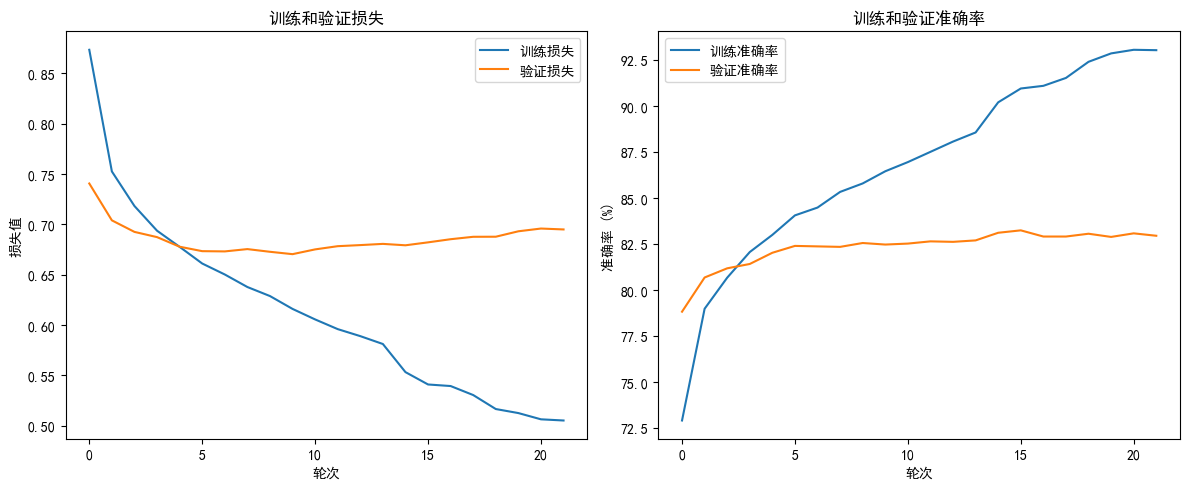

In [14]:
# 训练历史可视化
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='训练损失')
plt.plot(history['val_loss'], label='验证损失')
plt.title('训练和验证损失')
plt.xlabel('轮次')
plt.ylabel('损失值')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='训练准确率')
plt.plot(history['val_acc'], label='验证准确率')
plt.title('训练和验证准确率')
plt.xlabel('轮次')
plt.ylabel('准确率 (%)')
plt.legend()

plt.tight_layout()
plt.show()

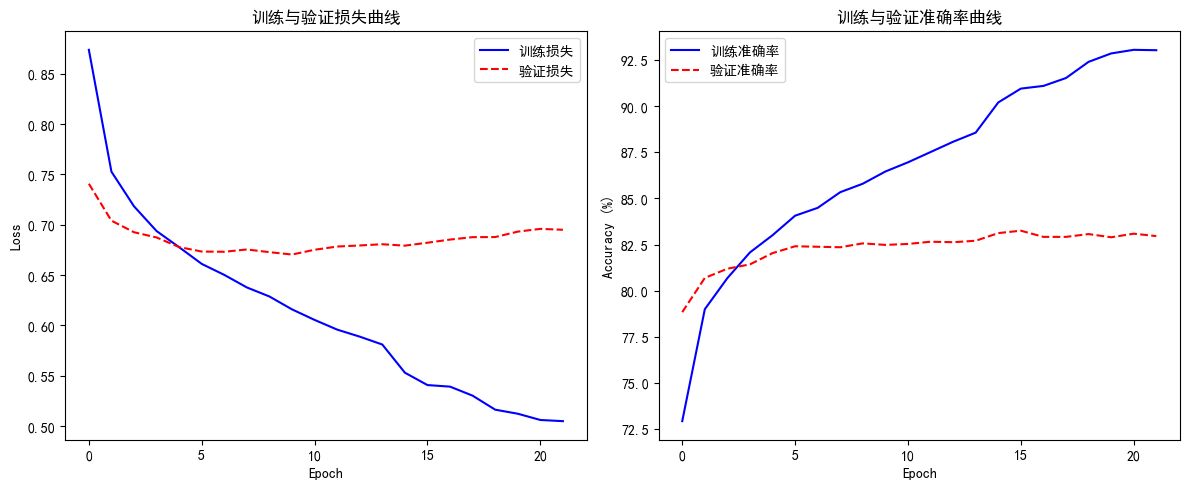

In [15]:
# 1. 训练曲线（损失和准确率）
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='训练损失', color='blue', linestyle='-')
plt.plot(history['val_loss'], label='验证损失', color='red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('训练与验证损失曲线')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='训练准确率', color='blue', linestyle='-')
plt.plot(history['val_acc'], label='验证准确率', color='red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('训练与验证准确率曲线')
plt.legend()

plt.tight_layout()
plt.show()

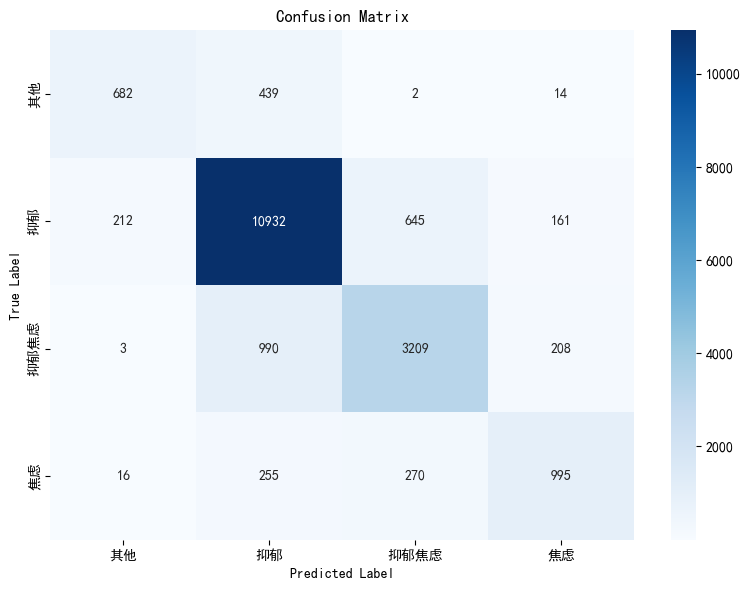

测试集准确率: 83.11%


In [16]:
# 混淆矩阵可视化
import seaborn as sns
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 计算测试准确率
test_accuracy = 100 * (y_pred == y_test).sum() / len(y_test)
print(f"测试集准确率: {test_accuracy:.2f}%")

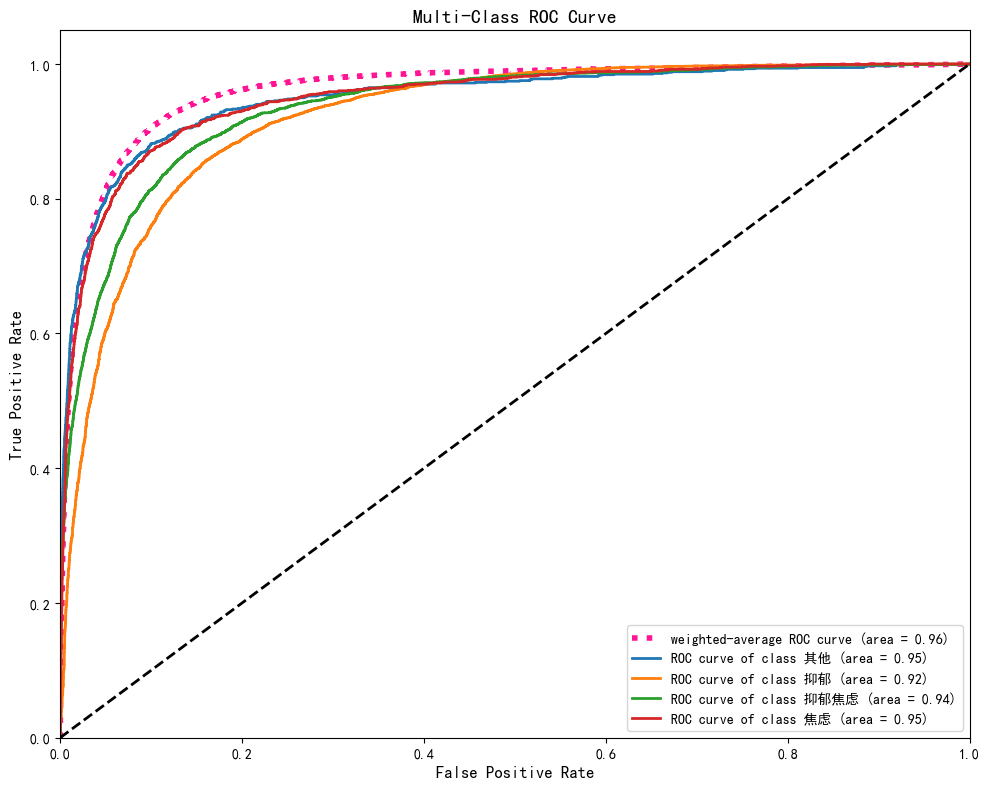

In [17]:
# 多分类ROC曲线可视化
from sklearn.preprocessing import label_binarize
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算微平均ROC曲线和AUC
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 8))
plt.plot(fpr["weighted"], tpr["weighted"],
         label='weighted-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["weighted"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
